# WEEK 2 visualizations

---

## Config

In [1]:
# --- Block 1 (fixed): Colab-only bootstrap with one-time restart -------------
import sys, os, subprocess, platform, time
from pathlib import Path

# Detect if code is running inside Google Colab by checking loaded modules.
# Side effect: enables Colab-specific behavior (Drive mount, pip pins, restart).
IN_COLAB = "google.colab" in sys.modules
print(f"🐍 Python: {sys.version.split()[0]} | Colab: {IN_COLAB}")

def sh(cmd: str):
    # Thin wrapper around subprocess.run for shell commands with simple error handling.
    # Raises SystemExit on non-zero return to halt the notebook early and surface the failing command.
    print(">>", cmd)
    r = subprocess.run(cmd, shell=True)
    if r.returncode != 0:
        raise SystemExit(r.returncode)

# Marker file used to prevent infinite restarts of the Colab runtime.
# Presence of this file indicates the first-run bootstrap has completed.
MARK = Path("/content/_cxr_bootstrap_done")

# Resolve project root depending on environment.
# In Colab: try common Drive locations, else fallback to current working directory.
# Outside Colab: allow override via CXR_PROJ_ROOT env var, else cwd.
if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)  # Avoid remount churn; user can toggle if needed.
    print("✅ Google Drive mounted")
    CANDIDATES = [
        Path("/content/drive/MyDrive/code/chest-xray-lab"),  # Preferred repo path
        Path("/content/drive/MyDrive/chest_xray_lab"),       # Alternate naming
        Path.cwd(),                                          # Fallback to notebook directory
    ]
else:
    CANDIDATES = [Path(os.environ.get("CXR_PROJ_ROOT", Path.cwd()))]

# Pick the first existing candidate as the canonical project root.
# Note: if multiple exist, ordering matters; consider logging a warning in multi-match situations.
PROJ_ROOT = next((p.resolve() for p in CANDIDATES if p.exists()), Path.cwd().resolve())
os.environ["CXR_PROJ_ROOT"] = str(PROJ_ROOT)  # Export for child processes (e.g., pip, editable install).
print("📁 PROJECT ROOT:", PROJ_ROOT)

# Add src/ to the import path to support 'editable-like' imports without installing.
SRC_DIR = PROJ_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# First-time bootstrap path (only in Colab and only if MARK doesn't exist yet).
# Performs pinning/uninstall to harmonize binary dependencies and avoid ABI mismatches.
if IN_COLAB and not MARK.exists():
    # Patch 'requires-python' in pyproject for Colab base kernels that lag behind.
    # Caution: mutates repository file; safe for Colab but avoid committing this change upstream.
    pyproject = PROJ_ROOT / "pyproject.toml"
    if pyproject.exists():
        txt = pyproject.read_text()
        if 'requires-python = ">=3.12"' in txt:
            print("⚠️ Patching requires-python to >=3.10 for Colab base kernel…")
            pyproject.write_text(txt.replace('requires-python = ">=3.12"', 'requires-python = ">=3.10"'))

    # Clean slate to prevent silent ABI conflicts (NumPy/Torch/Scipy stack).
    # Set CXR_FORCE_CLEAN=0 to skip aggressive uninstalls when debugging.
    if os.environ.get("CXR_FORCE_CLEAN", "1") == "1":
        sh("pip -q uninstall -y "
           "torch torchvision torchaudio "
           "numpy pandas scipy scikit-learn scikit-image "
           "matplotlib "
           "opencv-python opencv-contrib-python opencv-python-headless "
           "jax jaxlib pillow tabulate kagglehub captum torchcam || true")
        sh("pip -q install --upgrade pip")  # Keep pip recent to reduce resolver quirks.

    # 1) Pin NumPy FIRST to a version compatible with PyTorch 2.2 wheels on Colab.
    # Rationale: prevents resolver from upgrading NumPy to an ABI that mismatches Torch.
    sh("pip install --no-cache-dir numpy==1.26.4")

    # 2) Install Torch 2.2.2 with CUDA wheels where available; fallback logic handles Colab GPU variants.
    # Tries CUDA 12.1 then 11.8. If both fail (e.g., CPU runtime), installs CPU wheels from Torch index.
    for wheels in (
        "torch==2.2.2+cu121 torchvision==0.17.2+cu121 torchaudio==2.2.2+cu121",
        "torch==2.2.2+cu118 torchvision==0.17.2+cu118 torchaudio==2.2.2+cu118",
    ):
        try:
            sh(f"pip install --no-cache-dir -f https://download.pytorch.org/whl/torch_stable.html {wheels}")
            break
        except SystemExit:
            pass
    else:
        print("⚠️ GPU wheels failed; installing CPU wheels")
        sh("pip install --no-cache-dir --index-url https://download.pytorch.org/whl/cpu "
           "torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2")

    # 3) Install the rest of the scientific stack with strict pins where stability is critical.
    # Matplotlib pinned with fallback spec to accommodate transient wheel availability on Colab images.
    try:
        sh("pip install --no-cache-dir matplotlib==3.10.7")
    except SystemExit:
        sh("pip install --no-cache-dir 'matplotlib>=3.10,<3.11'")
    sh("pip install --no-cache-dir pandas==2.3.3 scipy==1.16.2 scikit-learn==1.7.2 scikit-image==0.25.2 tabulate==0.9.0 kagglehub==0.3.13")
    try:
        sh("pip install --no-cache-dir opencv-python==4.9.0.80")
    except SystemExit:
        # Headless fallback avoids GUI backends not present on Colab; functionality is similar for CV workloads.
        sh("pip install --no-cache-dir opencv-python-headless==4.9.0.80")

    # 4) Model interpretability tooling (optional extras).
    # Captum is aligned with Torch 2.2; TorchCAM kept optional to encourage custom Grad-CAM if desired.
    sh("pip install --no-cache-dir captum==0.7.0")
    # Optional: drop torchcam and implement Grad-CAM yourself
    # sh("pip install --no-cache-dir torchcam==0.4.0")

    # 5) Editable install of the repo WITHOUT dependency resolution.
    # --no-deps ensures previously pinned wheels aren't re-resolved by project metadata.
    sh(f"pip install --no-cache-dir -e {PROJ_ROOT} --no-deps")

    # 6) Create marker and force a hard restart to ensure the runtime imports the freshly pinned ABIs.
    # Using SIGKILL avoids partial state; the guard MARK prevents infinite restart loops.
    MARK.touch()
    import os as _os
    _os.kill(_os.getpid(), 9)

# Second run (post-restart): import and print versions to verify environment health.
# Skips all uninstall/install work; functions as a quick sanity check plus utility defs.
if IN_COLAB:
    import numpy as np, torch, cv2, pandas, scipy, sklearn, skimage, matplotlib
    print("python:", sys.version.split()[0], "|", platform.platform())
    print("numpy:", np.__version__)
    print("torch :", torch.__version__, "| CUDA?", torch.cuda.is_available())  # Note: torch.cuda.is_available() reflects driver/runtime availability.
    print("cv2   :", cv2.__version__)
    print("pandas:", pandas.__version__, "| scipy:", scipy.__version__)
    print("sklearn:", sklearn.__version__, "| skimage:", skimage.__version__)
    print("matplotlib:", matplotlib.__version__)

    # Lightweight, robust file writers for Google Drive to mitigate sync lag / buffering issues.
    # safe_write_bytes ensures data durability by fsync + size check with retries.
    import io
    def safe_write_bytes(path: Path, data: bytes, retries: int = 3, sleep_s: float = 0.5):
        path.parent.mkdir(parents=True, exist_ok=True)
        with open(path, "wb") as f:
            f.write(data); f.flush(); os.fsync(f.fileno())
        for _ in range(retries):
            if path.exists() and path.stat().st_size == len(data):
                return True
            time.sleep(sleep_s)
        raise IOError(f"Drive sync failed for {path}")
    def safe_write_text(path: Path, text: str): return safe_write_bytes(path, text.encode("utf-8"))
    globals().update(dict(safe_write_bytes=safe_write_bytes, safe_write_text=safe_write_text))
    # Note: safe_write_* return True on success; callers may want to assert the return or handle exceptions.


🐍 Python: 3.12.12 | Colab: True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted
📁 PROJECT ROOT: /content/drive/MyDrive/code/chest-xray-lab
python: 3.12.12 | Linux-6.6.105+-x86_64-with-glibc2.35
numpy: 1.26.4
torch : 2.2.2+cu121 | CUDA? True
cv2   : 4.9.0
pandas: 2.3.3 | scipy: 1.16.2
sklearn: 1.7.2 | skimage: 0.25.2
matplotlib: 3.10.7


---

## Fast i/o

In [2]:
from pathlib import Path
import os, shutil

# adapt to your project
PROJ_ROOT = Path("/content/drive/MyDrive/code/chest-xray-lab")

# this must match the one from notebook 1
PHASH = "3a0b791144"

DRIVE_IMG_ROOT = PROJ_ROOT / "data/processed/chest_xray_split" / f"cache_{PHASH}" / "images"
LOCAL_IMG_ROOT = Path(f"/content/chest_xray_cache/cache_{PHASH}/images")

LOCAL_IMG_ROOT.mkdir(parents=True, exist_ok=True)

def mirror_dir(src: Path, dst: Path):
    src = Path(src); dst = Path(dst)
    for split in ("train", "val", "test"):
        s = src / split
        d = dst / split
        if not s.exists():
            continue
        if d.exists():
            shutil.rmtree(d)
        shutil.copytree(s, d)

# try rsync if you want, but copytree is fine for 10 imgs
mirror_dir(DRIVE_IMG_ROOT, LOCAL_IMG_ROOT)

print("mirrored to:", LOCAL_IMG_ROOT)


mirrored to: /content/chest_xray_cache/cache_3a0b791144/images


---

## Baseline curves

common images: 10


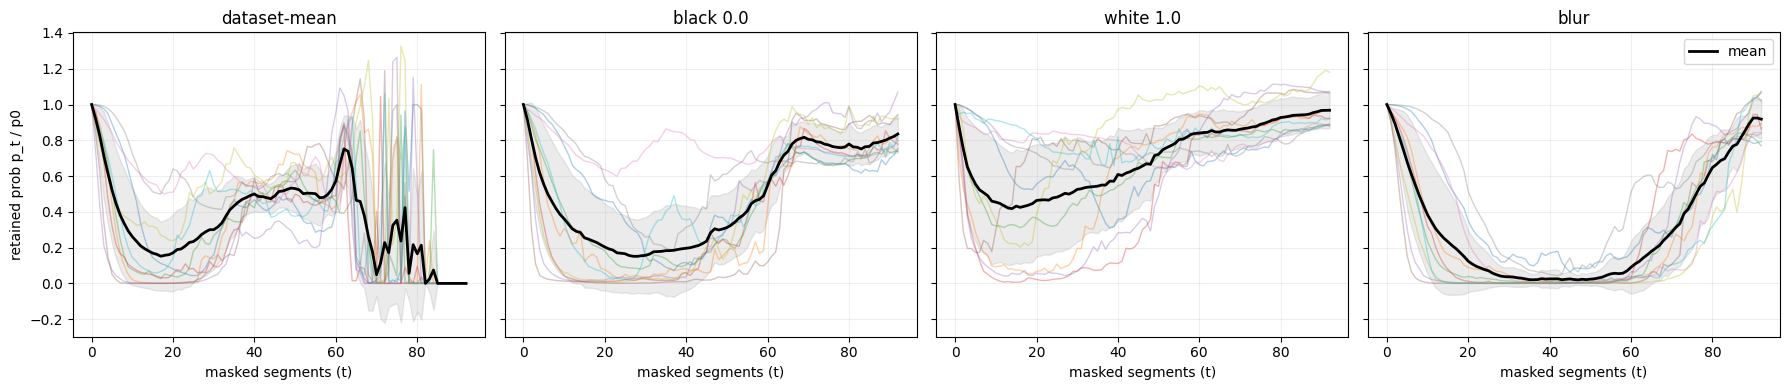

In [39]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from chest_xray_lab.explain.sofi_io import common_sofi_files, load_sofi_cache

ROOT_BASE  = Path(f"{PROJ_ROOT}/data/processed/manifests/week1_sofi_curves_base/arrays")
ROOT_BLACK = Path(f"{PROJ_ROOT}/data/processed/manifests/week1_sofi_curves_black/arrays")
ROOT_WHITE = Path(f"{PROJ_ROOT}/data/processed/manifests/week1_sofi_curves_white/arrays")
ROOT_BLUR = Path(f"{PROJ_ROOT}/data/processed/manifests/week1_sofi_curves_blur/arrays")


common = common_sofi_files(ROOT_BASE, ROOT_BLACK, ROOT_WHITE, ROOT_BLUR)
print("common images:", len(common))

curves = {
    "dataset-mean": [],
    "black 0.0": [],
    "white 1.0": [],
    "blur": [],
}

# collect
for fname in common:
    z_base,  m_base  = load_sofi_cache(ROOT_BASE,  fname)
    z_black, m_black = load_sofi_cache(ROOT_BLACK, fname)
    z_white, m_white = load_sofi_cache(ROOT_WHITE, fname)
    z_blur, m_blur = load_sofi_cache(ROOT_BLUR, fname)

    curves["dataset-mean"].append(z_base["y_hl"])
    curves["black 0.0"].append(z_black["y_hl"])
    curves["white 1.0"].append(z_white["y_hl"])
    curves["blur"].append(z_blur["y_hl"])


baseline_names = ["dataset-mean", "black 0.0", "white 1.0", "blur"]

fig, axes = plt.subplots(1, len(baseline_names), figsize=(18, 4), sharey=True)

for ax, name in zip(axes, baseline_names):
    ys = curves[name]
    # defensive: skip if somehow empty
    if not ys:
        ax.set_title(f"{name} (empty)")
        continue

    lens = [len(y) for y in ys]
    Lmin = min(lens)
    Y = np.stack([y[:Lmin] for y in ys], axis=0)
    x = np.arange(Lmin)

    for i in range(Y.shape[0]):
        ax.plot(x, Y[i], alpha=0.35, linewidth=1)

    mu = Y.mean(axis=0)
    sd = Y.std(axis=0)
    ax.plot(x, mu, color="black", linewidth=2, label="mean")
    ax.fill_between(x, mu - sd, mu + sd, color="black", alpha=0.08)

    ax.set_title(name)
    ax.set_xlabel("masked segments (t)")
    ax.grid(True, alpha=0.2)

axes[0].set_ylabel("retained prob p_t / p0")
axes[-1].legend(loc="best")
plt.tight_layout()
plt.show()



---

## Baseline curves incl. RAND

common images: 10


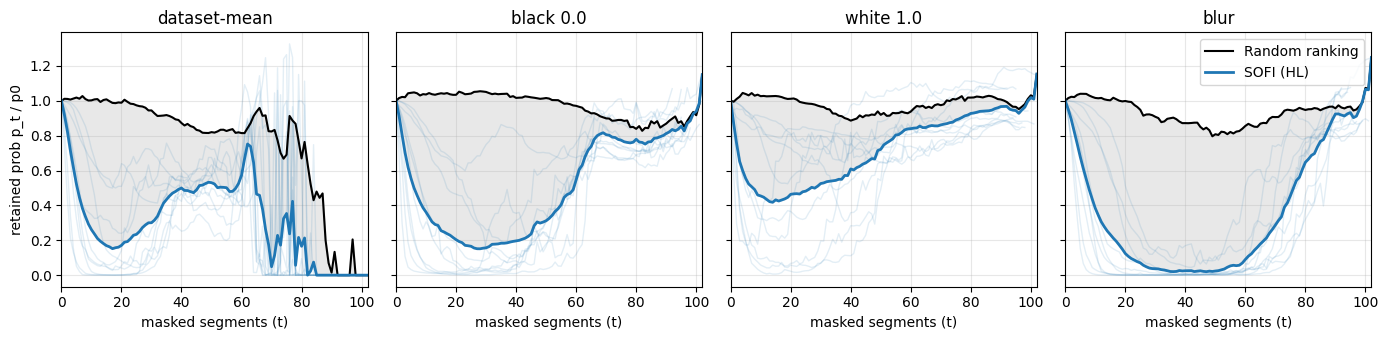

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from chest_xray_lab.explain.sofi_io import common_sofi_files, load_sofi_cache

ROOTS = {
    "dataset-mean": Path(f"{PROJ_ROOT}/data/processed/manifests/week1_sofi_curves_base/arrays"),
    "black 0.0":     Path(f"{PROJ_ROOT}/data/processed/manifests/week1_sofi_curves_black/arrays"),
    "white 1.0":     Path(f"{PROJ_ROOT}/data/processed/manifests/week1_sofi_curves_white/arrays"),
    "blur":     Path(f"{PROJ_ROOT}/data/processed/manifests/week1_sofi_curves_blur/arrays"),

}

common = common_sofi_files(*ROOTS.values())
print("common images:", len(common))

def pad_to(x, L):
    out = np.ones(L, dtype=np.float32) * np.nan
    out[:len(x)] = x
    return out

# collect per-baseline curves
curves_hl = {name: [] for name in ROOTS}
curves_rand = {name: [] for name in ROOTS}
max_len = 0

for fname in common:
    for name, root in ROOTS.items():
        z, meta = load_sofi_cache(root, fname)
        y_hl = z["y_hl"].astype(np.float32)
        y_rand = z.get("y_rand", None)
        curves_hl[name].append(y_hl)
        if y_rand is not None:
            curves_rand[name].append(y_rand.astype(np.float32))
        max_len = max(max_len, len(y_hl))

fig, axes = plt.subplots(1, 4, figsize=(14, 3.5), sharey=True)
for ax, (name, ys_hl) in zip(axes, curves_hl.items()):
    # pad
    Y_hl = np.stack([pad_to(y, max_len) for y in ys_hl], axis=0)  # [N, T]
    mean_hl = np.nanmean(Y_hl, axis=0)

    # rand (if present)
    if curves_rand[name]:
        Y_rand = np.stack([pad_to(y, max_len) for y in curves_rand[name]], axis=0)
        mean_rand = np.nanmean(Y_rand, axis=0)
    else:
        mean_rand = None

    x = np.arange(max_len)

    # light per-image lines
    for row in Y_hl:
        ax.plot(x, row, color="C0", alpha=0.12, linewidth=1)

    # rand curve
    if mean_rand is not None:
        ax.plot(x, mean_rand, color="black", linewidth=1.5, label="Random ranking")

        # fill like in slide (area between rand and expl)
        ax.fill_between(x, mean_rand, mean_hl, where=(~np.isnan(mean_rand) & ~np.isnan(mean_hl)),
                        color="0.85", alpha=0.6)

    # expl curve
    ax.plot(x, mean_hl, color="C0", linewidth=2.0, label="SOFI (HL)")

    ax.set_title(name)
    ax.set_xlabel("masked segments (t)")
    ax.set_xlim(0, max_len-1)
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("retained prob p_t / p0")
axes[-1].legend(loc="upper right")
plt.tight_layout()
plt.show()


---

## Progressive plots of occlusions (dataset-mean, k=140)

In [23]:
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt

from chest_xray_lab.explain.sofi_io import load_sofi_cache
from chest_xray_lab.data.io import load_gray01

# ---- paths / constants ----
MANIFESTS = Path(f"{PROJ_ROOT}/data/processed/manifests")
part0 = json.loads((MANIFESTS / "part0_min.json").read_text())
MEAN01 = float(part0["train_mean01"])
print("dataset mean (MEAN01) =", MEAN01)

ROOT_DSMEAN_K140 = Path(
    f"{PROJ_ROOT}/data/processed/manifests/week1_sofi_curves_ds-mean_k60_hc300/arrays"
)

BINS = [0.2, 0.4, 0.6, 0.8, 1.0]


# ---- helpers ----
def _make_occlusion_mask(segmap: np.ndarray, order: np.ndarray, n_mask: int) -> np.ndarray:
    """Boolean mask of occluded segments (True = occluded)."""
    n_mask = int(np.clip(n_mask, 0, len(order)))
    if n_mask == 0:
        return np.zeros_like(segmap, dtype=bool)
    active = set(order[:n_mask].tolist())
    return np.isin(segmap, list(active))


def _seg_edges(segmap: np.ndarray) -> np.ndarray:
    """Return a boolean mask of superpixel boundaries."""
    s = segmap
    edges = np.zeros_like(s, dtype=bool)
    edges[1:, :] |= s[1:, :] != s[:-1, :]
    edges[:-1, :] |= s[1:, :] != s[:-1, :]
    edges[:, 1:] |= s[:, 1:] != s[:, :-1]
    edges[:, :-1] |= s[:, 1:] != s[:, :-1]
    return edges


def _infer_img_and_p0(z, meta, npz_path: Path):
    """Try to recover (img_path, img_array, p0) from the SOFI cache."""
    img_keys = ["img", "img_path", "path", "fname", "image"]
    img_path = None
    for k in img_keys:
        if k in meta:
            img_path = meta[k]
            break

    if img_path is None:
        # maybe the image itself is cached
        for k in ["g0", "gray", "gray01", "image"]:
            if k in z:
                return None, z[k], meta.get("p0", None)
        raise KeyError(
            f"Could not find an image path or image array in cache for {npz_path}.\n"
            f"meta keys: {list(meta.keys())}\n"
            f"z keys: {list(z.keys())}"
        )

    p0 = meta.get("p0", None)
    return img_path, None, p0


def show_sofi_progression_dataset_mean(npz_path: Path,
                                       bins=BINS,
                                       cmap_img="gray", case=1):
    """
    SOFI masking progression for a single image, using the dataset-mean
    value as the occlusion baseline.

    Background is cumulative (more of the image flattened to MEAN01 over time),
    but each panel only outlines the segments that are FIRST occluded in that
    bin, with a specific colour per bin.
    """
    # load cache from DATASET-MEAN root
    z, meta = load_sofi_cache(ROOT_DSMEAN_K140, npz_path.name)

    y = z["y_hl"]              # retained ratios p_t / p_0
    segmap = z["segmap"]       # HxW, int labels
    order = z.get("order_hl", z.get("order", None))
    if order is None:
        raise KeyError("Expected 'order_hl' or 'order' in SOFI cache.")
    order = np.asarray(order, dtype=int)
    K = int(segmap.max()) + 1
    t_max = len(y) - 1

    # original image + p0
    img_path, img_array, p0 = _infer_img_and_p0(z, meta, npz_path)
    if img_array is not None:
        g0 = img_array.astype(np.float32)
    else:
        g0 = load_gray01(img_path).astype(np.float32)

    # dataset-mean baseline image
    baseline_img = np.full_like(g0, MEAN01, dtype=np.float32)

    seg_edges = _seg_edges(segmap)

    # convert bin fractions -> integer t-steps
    t_steps = []
    for frac in bins:
        t = int(round(frac * K))
        t = int(np.clip(t, 0, t_max))
        t_steps.append(t)

    # assign each segment to the bin where it FIRST becomes occluded
    seg_rank = np.empty(K, dtype=int)
    seg_rank[order] = np.arange(K, dtype=int)

    bin_idx = np.full(K, -1, dtype=int)  # -1 = never (shouldn’t happen)
    prev_t = 0
    for j, t in enumerate(t_steps):
        mask = (seg_rank >= prev_t) & (seg_rank < t)
        bin_idx[mask] = j
        prev_t = t
    bin_per_pixel = bin_idx[segmap]  # HxW ints in [-1, len(bins)-1]

    # colours per bin
    bin_colors = ["tab:red", "tab:blue", "tab:green", "tab:purple", "tab:orange"]
    assert len(bin_colors) >= len(bins)

    # --------  layout: rows of 3 panels  --------
    n_panels = 1 + len(bins)      # original + snapshots
    n_cols = 6
    n_rows = int(np.ceil(n_panels / n_cols))

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(3.2 * n_cols, 3.8 * n_rows),
        constrained_layout=True,
    )
    # flatten axes for easy indexing
    axes = np.array(axes).ravel()

    # panel 0: original
    ax0 = axes[0]
    ax0.imshow(g0, cmap=cmap_img, vmin=0.0, vmax=1.0)
    ax0.set_title("Original CXR", fontsize=11)
    ax0.axis("off")

    # snapshots in panels 1..n_panels-1
    for panel_idx, (frac, t) in enumerate(zip(bins, t_steps), start=1):
        ax = axes[panel_idx]

        # cumulative mask = all segments occluded up to this step
        occluded_mask = _make_occlusion_mask(segmap, order, t)

        # background = original with those segments set to dataset mean
        bg = g0.copy()
        bg[occluded_mask] = baseline_img[occluded_mask]
        ax.imshow(bg, cmap=cmap_img, vmin=0.0, vmax=1.0)

        # NEW segments in this bin only (for outlines)
        this_bin = panel_idx - 1      # because bins start at index 0
        new_seg_mask = (bin_per_pixel == this_bin)

        edge_mask = seg_edges & new_seg_mask
        outline = np.zeros((*g0.shape, 4), dtype=np.float32)
        rgb = np.array(plt.matplotlib.colors.to_rgb(bin_colors[this_bin]), dtype=np.float32)
        outline[edge_mask, :3] = rgb
        outline[edge_mask, 3] = 1.0
        ax.imshow(outline)

        # title with probs
        p_rel = float(y[t])
        if p0 is not None:
            p_abs = p_rel * float(p0)
            title = rf"$t/K={frac:.1f}$  $p_t/p_0={p_rel:.2f}$  $p_t={p_abs:.2f}$"
        else:
            title = rf"$t/K={frac:.1f}$  $p_t/p_0={p_rel:.2f}$"
        ax.set_title(title, fontsize=9)
        ax.axis("off")

    # hide any unused axes (if n_panels < n_rows*n_cols)
    for k in range(n_panels, len(axes)):
        axes[k].axis("off")

    base_name = str(img_path).split('/')[-1] if img_path is not None else npz_path.name
    if p0 is not None:
        fig.suptitle(
            rf"SOFI masking progression (dataset-mean, $K=140$) — {base_name}  ($p_0={p0:.2f}$)",
            fontsize=12
        )
    else:
        fig.suptitle(
            rf"SOFI masking progression (dataset-mean, $K=140$) — {base_name}",
            fontsize=12
        )

    plt.show()
    plt.savefig(f"sofi_progression_dmean_k140_case{i}.png")


dataset mean (MEAN01) = 0.5751695000756363


In [27]:
npz_files = sorted(ROOT_DSMEAN_K140.glob("*.npz"))
i = 1
for f in npz_files:
  print(i)
  show_sofi_progression_dataset_mean(f, case=i)
  i += 1



Output hidden; open in https://colab.research.google.com to view.

---

## Curves for ablation on blur with `max_iters` = 300,500,700

common images: 0


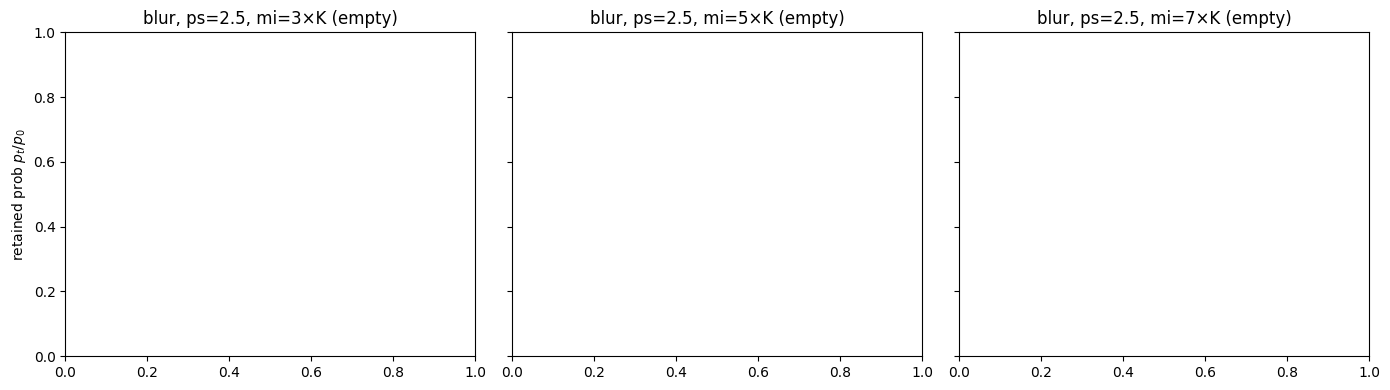

In [6]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from chest_xray_lab.explain.sofi_io import common_sofi_files, load_sofi_cache

# dirs you showed
ROOT_MI3 = Path(f"{PROJ_ROOT}/data/processed/manifests/week1_sofi_curves_blur_ps2.5_mi3x/arrays")
ROOT_MI5 = Path(f"{PROJ_ROOT}/data/processed/manifests/week1_sofi_curves_blur_ps2.5_mi5x/arrays")
ROOT_MI7 = Path(f"{PROJ_ROOT}/data/processed/manifests/week1_sofi_curves_blur_ps2.5_mi7x/arrays")

roots = {
    "blur, ps=2.5, mi=3×K": ROOT_MI3,   # 3 * 100 = 300 iters
    "blur, ps=2.5, mi=5×K": ROOT_MI5,   # 5 * 100 = 500 iters
    "blur, ps=2.5, mi=7×K": ROOT_MI7,   # 7 * 100 = 700 iters
}

# only plot images that exist in *all* 3 runs
common = common_sofi_files(*roots.values())
print("common images:", len(common))

def auc_uniform_01(y: np.ndarray) -> float:
    y = np.asarray(y, dtype=np.float32)
    if y.size < 2:
        return float(y.mean() if y.size else 0.0)
    dx = 1.0 / (len(y) - 1)
    trap = getattr(np, "trapezoid", np.trapz)
    return float(trap(y, dx=dx))

# collect curves
curves = {name: [] for name in roots}
for fname in common:
    for name, root in roots.items():
        z, meta = load_sofi_cache(root, fname)
        curves[name].append(z["y_hl"])

# plot
fig, axes = plt.subplots(1, len(roots), figsize=(14, 4), sharey=True)

for ax, (name, ys) in zip(axes, curves.items()):
    if not ys:
        ax.set_title(f"{name} (empty)")
        continue

    # make all same length
    lens = [len(y) for y in ys]
    Lmin = min(lens)
    Y = np.stack([y[:Lmin] for y in ys], axis=0)
    x = np.arange(Lmin)

    # thin per-image
    for i in range(Y.shape[0]):
        ax.plot(x, Y[i], alpha=0.35, linewidth=1)

    mu = Y.mean(axis=0)
    sd = Y.std(axis=0)

    # AUC over raw curves
    aucs = [auc_uniform_01(y[:Lmin]) for y in ys]
    auc_mean = float(np.mean(aucs))
    auc_std  = float(np.std(aucs, ddof=1)) if len(aucs) > 1 else 0.0

    ax.plot(x, mu, color="black", linewidth=2,
            label=f"mean (AUC={auc_mean:.3f}±{auc_std:.3f})")
    ax.fill_between(x, mu - sd, mu + sd, color="black", alpha=0.08)

    ax.set_title(name)
    ax.set_xlabel("masked segments (t)")
    ax.grid(True, alpha=0.2)
    ax.legend(loc="best")

axes[0].set_ylabel("retained prob $p_t / p_0$")
plt.tight_layout()
plt.show()


---

## Curves for ablation on `ds-mean` with K = 60,80,100,120,140

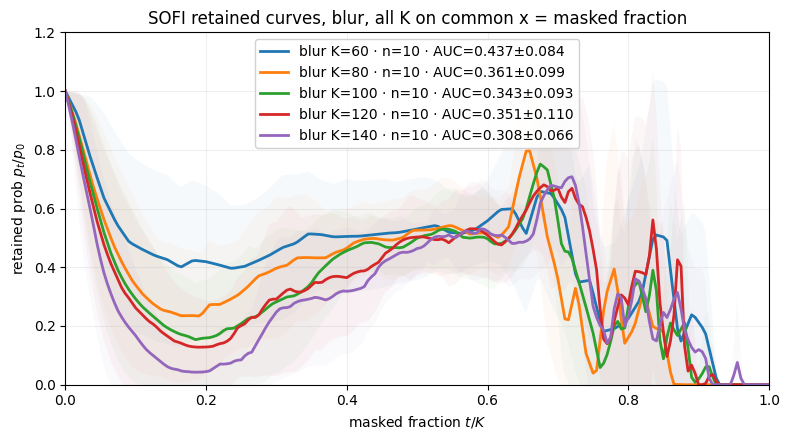

<Figure size 640x480 with 0 Axes>

In [7]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from chest_xray_lab.explain.sofi_io import load_sofi_cache

ROOTS = {
    "blur K=60":  Path(f"{PROJ_ROOT}/data/processed/manifests/week1_sofi_curves_ds-mean_k60_hc300/arrays"),
    "blur K=80":  Path(f"{PROJ_ROOT}/data/processed/manifests/week1_sofi_curves_ds-mean_k80_hc400/arrays"),
    "blur K=100": Path(f"{PROJ_ROOT}/data/processed/manifests/week1_sofi_curves_ds-mean_k100_hc500/arrays"),
    "blur K=120": Path(f"{PROJ_ROOT}/data/processed/manifests/week1_sofi_curves_ds-mean_k120_hc600/arrays"),
    "blur K=140": Path(f"{PROJ_ROOT}/data/processed/manifests/week1_sofi_curves_ds-mean_k140_hc700/arrays"),
}

def auc_uniform_01(y: np.ndarray) -> float:
    y = np.asarray(y, dtype=np.float32)
    if y.size < 2:
        return float(y.mean() if y.size else 0.0)
    dx = 1.0 / (len(y) - 1)
    trap = getattr(np, "trapezoid", np.trapz)
    return float(trap(y, dx=dx))

# 1) collect per-root maps (basename -> path)
per_root_maps = {}
all_basenames = set()
for name, root in ROOTS.items():
    m = {}
    for p in root.glob("*.npz"):
        stem = p.name
        if "__" in stem:
            base = stem.split("__", 1)[1].rsplit(".npz", 1)[0]
        else:
            base = stem.rsplit(".npz", 1)[0]
        m[base] = p
        all_basenames.add(base)
    per_root_maps[name] = m

# 2) load curves per K (no global truncation!)
curves = {name: [] for name in ROOTS}
for base in sorted(all_basenames):
    for name, m in per_root_maps.items():
        if base not in m:
            continue
        p = m[base]
        z, meta = load_sofi_cache(ROOTS[name], p.name)
        if "y_hl" in z:
            curves[name].append(z["y_hl"])

# 3) build a common x-grid in [0,1]
X_common = np.linspace(0.0, 1.0, 201)

# sort Ks nicely
def _extract_k(label: str) -> int:
    return int(label.split("K=")[1])

sorted_items = sorted(curves.items(), key=lambda kv: _extract_k(kv[0]))

fig, ax = plt.subplots(figsize=(8, 4.5))

for name, ys in sorted_items:
    if not ys:
        continue

    # make all curves for this K the same length (per-K min, not global min)
    lens = [len(y) for y in ys]
    Lk = min(lens)
    Yk = np.stack([y[:Lk] for y in ys], axis=0)

    # x for this K is 0..1
    Xk = np.linspace(0.0, 1.0, Lk)

    mu = Yk.mean(axis=0)
    sd = Yk.std(axis=0)

    # interpolate onto common grid
    mu_i = np.interp(X_common, Xk, mu)
    sd_i = np.interp(X_common, Xk, sd)

    # AUCs should be computed on the *original* per-K normalised x
    aucs = [auc_uniform_01(y[:Lk]) for y in ys]
    auc_mean = float(np.mean(aucs))
    auc_std  = float(np.std(aucs, ddof=1)) if len(aucs) > 1 else 0.0

    # pick a thin line for K, thick line for mean
    ax.plot(
        X_common,
        mu_i,
        linewidth=2,
        label=f"{name} · n={len(ys)} · AUC={auc_mean:.3f}±{auc_std:.3f}",
    )
    ax.fill_between(X_common, mu_i - sd_i, mu_i + sd_i, alpha=0.04)

ax.set_title("SOFI retained curves, ds-mean, all K on common x = masked fraction")
ax.set_xlabel("masked fraction $t/K$")
ax.set_ylabel(r"retained prob $p_t / p_0$")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.2)
ax.grid(True, alpha=0.2)
ax.legend(loc="upper center", frameon=True, framealpha=0.9)
plt.tight_layout()
plt.show()
plt.savefig('sofi_segment_ablation_common_scale.png')

---

## SOFI vs SOTA curves

In [29]:
print("SOFI root:", SOFI_ROOT)
print("SOTA root:", SOTA_ROOT)

print("\nSOFI npz count:", len(list(SOFI_ROOT.glob("*.npz"))))

for nice_name, tag in SOTA_METHOD_TAGS.items():
    pattern = f"sota_{tag}_K{K}_c10_s10_lab0_{BASELINE}__*.npz"
    files = list(SOTA_ROOT.glob(pattern))
    print(f"{nice_name:12s} pattern: {pattern}")
    print(f"  -> {len(files)} files")
    if files:
        print("     e.g.", files[0].name)


SOFI root: /content/drive/MyDrive/code/chest-xray-lab/data/processed/manifests/week1_sofi_curves_ds-mean_k140_hc700/arrays
SOTA root: /content/drive/MyDrive/code/chest-xray-lab/data/processed/manifests/week1_sota_curves

SOFI npz count: 10
Score-CAM    pattern: sota_ScoreCAM_K140_c10_s10_lab0_dataset-mean__*.npz
  -> 10 files
     e.g. sota_ScoreCAM_K140_c10_s10_lab0_dataset-mean__person112_bacteria_538.npz
Occ. sens.   pattern: sota_OccSensitivity_K140_c10_s10_lab0_dataset-mean__*.npz
  -> 10 files
     e.g. sota_OccSensitivity_K140_c10_s10_lab0_dataset-mean__person112_bacteria_538.npz
DeepLIFT     pattern: sota_DeepLIFT_K140_c10_s10_lab0_dataset-mean__*.npz
  -> 10 files
     e.g. sota_DeepLIFT_K140_c10_s10_lab0_dataset-mean__person112_bacteria_538.npz


Loaded SOFI curves: 10
Loaded ScoreCAM curves: 10
Loaded OccSensitivity curves: 10
Loaded DeepLIFT curves: 10
Common images used: 10
Example common names: ['person112_bacteria_538', 'person115_virus_219', 'person1439_virus_2453']


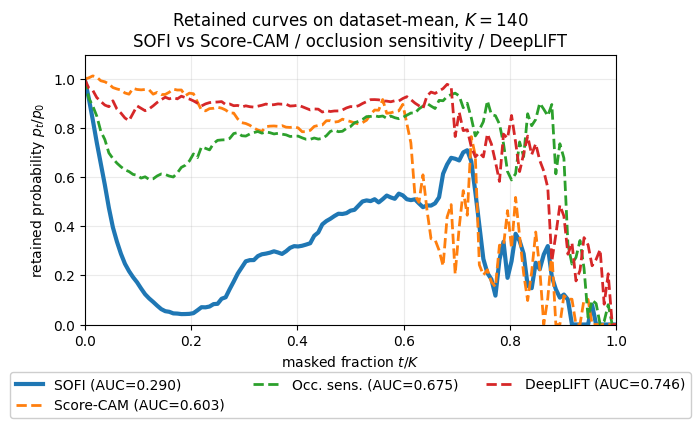

In [38]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from chest_xray_lab.explain.sofi_io import load_sofi_cache

# ------------------------------------------------------------
# 1) Paths & config
# ------------------------------------------------------------
K = 140
BASELINE = "dataset-mean"

SOFI_ROOT = Path(
    f"{PROJ_ROOT}/data/processed/manifests/week1_sofi_curves_ds-mean_k{K}_hc700/arrays"
)
SOTA_ROOT = MANIFESTS / "week1_sota_curves"

SOTA_METHOD_TAGS = {
    "Score-CAM":  "ScoreCAM",
    "Occ. sens.": "OccSensitivity",
    "DeepLIFT":   "DeepLIFT",
}

# AUCs from your table, row K=140
AUC_K140 = {
    "SOFI":      0.290,
    "Score-CAM": 0.603,
    "Occ. sens.":0.675,
    "DeepLIFT":  0.746,
    # "RAND":      0.799,
}

# ------------------------------------------------------------
# 2) Helpers
# ------------------------------------------------------------
def _basename_from_stem(stem: str) -> str:
    """
    Return image basename after the double underscore,
    with any image extension stripped.
    """
    if "__" in stem:
        base = stem.split("__", 1)[1].rsplit(".npz", 1)[0]
    else:
        base = stem.rsplit(".npz", 1)[0]

    # strip common image extensions if present
    for ext in [".jpeg", ".jpg", ".png"]:
        if base.endswith(ext):
            base = base[: -len(ext)]
            break
    return base

def load_sofi_curves(root: Path) -> dict:
    curves = {}
    for p in root.glob("*.npz"):
        z, meta = load_sofi_cache(root, p.name)
        y = z.get("y_hl", z.get("y", None))
        if y is None:
            continue
        base = _basename_from_stem(p.name)
        curves[base] = np.asarray(y, dtype=np.float32)
    print("Loaded SOFI curves:", len(curves))
    return curves

def load_sota_curves(method_tag: str) -> dict:
    curves = {}
    pattern = f"sota_{method_tag}_K{K}_c10_s10_lab0_{BASELINE}__*.npz"
    for p in SOTA_ROOT.glob(pattern):
        data = np.load(p)
        if "y" not in data:
            continue
        base = _basename_from_stem(p.name)
        curves[base] = data["y"].astype(np.float32)
    print(f"Loaded {method_tag} curves:", len(curves))
    return curves

def stack_mean(curve_list, L_common=None):
    if not curve_list:
        return None, 0
    lens = [len(c) for c in curve_list]
    L = min(lens) if L_common is None else min(L_common, min(lens))
    Y = np.stack([c[:L] for c in curve_list], axis=0)
    return Y.mean(axis=0), L

# ------------------------------------------------------------
# 3) Collect curves and restrict to common images
# ------------------------------------------------------------
sofi_curves = load_sofi_curves(SOFI_ROOT)

sota_curves = {}
for nice_name, tag in SOTA_METHOD_TAGS.items():
    sota_curves[nice_name] = load_sota_curves(tag)

common_imgs = set(sofi_curves.keys())
for d in sota_curves.values():
    common_imgs &= set(d.keys())
common_imgs = sorted(common_imgs)

print("Common images used:", len(common_imgs))
print("Example common names:", common_imgs[:3])

# build per-method lists of curves (aligned image set)
method_curves = {
    "SOFI": [sofi_curves[b] for b in common_imgs]
}
for nice_name, d in sota_curves.items():
    method_curves[nice_name] = [d[b] for b in common_imgs]

# ------------------------------------------------------------
# 4) Build common x-axis and plot (no std bands)
# ------------------------------------------------------------
all_lens = []
for curves in method_curves.values():
    for c in curves:
        all_lens.append(len(c))
if not all_lens:
    raise RuntimeError("No curves found for common images – check filenames again.")

L_common = min(all_lens)
x = np.linspace(0.0, 1.0, L_common)

colors = {
    "SOFI":      "tab:blue",
    "Score-CAM": "tab:orange",
    "Occ. sens.":"tab:green",
    "DeepLIFT":  "tab:red",
    # "RAND":      "black",
}
linestyles = {
    "SOFI":      "-",
    "Score-CAM": "--",
    "Occ. sens.":"--",
    "DeepLIFT":  "--",
    # "RAND":      ":",
}
order = ["SOFI", "Score-CAM", "Occ. sens.", "DeepLIFT"]

fig, ax = plt.subplots(figsize=(7, 4.5))

for name in order:
    curves = method_curves.get(name, [])
    if not curves:
        continue
    mu, L_used = stack_mean(curves, L_common=L_common)
    x_used = x[:L_used]

    lw = 3 if name == "SOFI" else 2
    label = f"{name} (AUC={AUC_K140[name]:.3f})"

    ax.plot(
        x_used,
        mu,
        label=label,
        color=colors[name],
        linestyle=linestyles[name],
        linewidth=lw,
    )

# # RAND as horizontal baseline with AUC from table
# rand_y = AUC_K140["RAND"]
# ax.hlines(
#     rand_y,
#     0.0,
#     1.0,
#     colors=colors["RAND"],
#     linestyles=linestyles["RAND"],
#     linewidth=2,
#     label=f"RAND (AUC={rand_y:.3f})",
# )

ax.set_title(
    r"Retained curves on dataset-mean, $K=140$"
    "\nSOFI vs Score-CAM / occlusion sensitivity / DeepLIFT"
)
ax.set_xlabel(r"masked fraction $t/K$")
ax.set_ylabel(r"retained probability $p_t/p_0$")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.25)

ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    frameon=True,
    framealpha=0.95,
)

plt.tight_layout()
plt.show()
# plt.savefig("sofi_vs_sota_k140_datasetmean_with_rand.png", dpi=300, bbox_inches="tight")


---

## SOFI vs SOTA top k segments

In [48]:
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt

from chest_xray_lab.explain.sofi_io import load_sofi_cache
from chest_xray_lab.data.io import load_gray01

# ------------------------------------------------------------
# Paths / constants
# ------------------------------------------------------------
MANIFESTS = Path(f"{PROJ_ROOT}/data/processed/manifests")

K = 140                    # "nominal" K used in filenames / configs
BASELINE = "dataset-mean"

SOFI_ROOT = Path(
    f"{PROJ_ROOT}/data/processed/manifests/week1_sofi_curves_ds-mean_k{K}_hc700/arrays"
)
SOTA_ROOT = MANIFESTS / "week1_sota_curves"

# mapping "pretty name" -> method tag used in SOTA filenames
SOTA_METHOD_TAGS = {
    "Score-CAM":  "ScoreCAM",
    "Occ. sens.": "OccSensitivity",
    "DeepLIFT":   "DeepLIFT",
}

TOP_N = 20  # top-20 segments


# ------------------------------------------------------------
# Small helpers
# ------------------------------------------------------------
def _basename_from_stem(stem: str) -> str:
    """Return image basename after the double underscore."""
    if "__" in stem:
        return stem.split("__", 1)[1].rsplit(".npz", 1)[0]
    return stem.rsplit(".npz", 1)[0]


def _seg_edges(segmap: np.ndarray) -> np.ndarray:
    """Return a boolean mask of superpixel boundaries."""
    s = segmap
    edges = np.zeros_like(s, dtype=bool)

    # vertical neighbours (up/down)
    edges[1:, :]  |= (s[1:, :]  != s[:-1, :])   # compare row i with i-1
    edges[:-1, :] |= (s[:-1, :] != s[1:, :])    # symmetric

    # horizontal neighbours (left/right)
    edges[:, 1:]  |= (s[:, 1:]  != s[:, :-1])   # compare col j with j-1
    edges[:, :-1] |= (s[:, :-1] != s[:, 1:])    # symmetric

    return edges



# ------------------------------------------------------------
# Main plotting function
# ------------------------------------------------------------
def plot_top20_segments_all_methods(sofi_npz_path: Path,
                                    top_n: int = TOP_N,
                                    cmap_img: str = "gray"):
    """
    For a single case (given by its SOFI .npz path), show:
      - Original image
      - SOFI top-N segments
      - Score-CAM top-N
      - Occlusion sensitivity top-N
      - DeepLIFT top-N
    all on dataset-mean, nominal K=140.
    """
    # ---- load SOFI cache ----
    z_sofi, meta_sofi = load_sofi_cache(SOFI_ROOT, sofi_npz_path.name)

    segmap = z_sofi["segmap"].astype(np.int32)
    K_here = int(segmap.max()) + 1

    # SOFI segment order
    order_sofi = z_sofi.get("order_hl", z_sofi.get("order", None))
    if order_sofi is None:
        raise KeyError("No 'order_hl' or 'order' in SOFI cache.")
    order_sofi = np.asarray(order_sofi, dtype=int)
    K_order = len(order_sofi)

    if K_here != K_order:
        print(
            f"⚠️ segmap has {K_here} labels, but SOFI order length is {K_order} "
            f"(nominal K={K}). Using order length for ranking and segmap as-is."
        )

    # ---- recover original image ----
    img_path = None
    for k in ["img", "img_path", "path", "fname", "image"]:
        if k in meta_sofi:
            img_path = meta_sofi[k]
            break

    g0 = None
    if img_path is not None:
        try:
            g0 = load_gray01(img_path).astype(np.float32)
        except Exception as e:
            print(f"⚠️ Could not load image from path {img_path}: {e}")

    if g0 is None:
        # fall back to cached image array inside the npz, if present
        for k in ["g0", "gray01", "gray", "image"]:
            if k in z_sofi:
                g0 = np.asarray(z_sofi[k], dtype=np.float32)
                print(f"Using cached image array '{k}' from SOFI npz.")
                break

    if g0 is None:
        raise KeyError(
            f"Could not recover an image for {sofi_npz_path.name}.\n"
            f"meta keys: {list(meta_sofi.keys())}\n"
            f"z keys: {list(z_sofi.keys())}"
        )

    # segmentation edges (for optional outlines)
    seg_edges = _seg_edges(segmap)

    # ---- load SOTA orders for this same image ----
    base = _basename_from_stem(sofi_npz_path.name)
    sota_orders = {}

    # strip any trailing image extension from base (".jpeg", ".png", etc.)
    base_no_ext = base.split(".")[0]

    for nice_name, tag in SOTA_METHOD_TAGS.items():
        pattern = f"sota_{tag}_K{K}_c10_s10_lab0_{BASELINE}__{base_no_ext}*.npz"
        matches = list(SOTA_ROOT.glob(pattern))
        if not matches:
            print(f"⚠️ Missing SOTA file for {nice_name}: {pattern}")
            sota_orders[nice_name] = None
            continue

        p = matches[0]  # there should be exactly one
        data = np.load(p)
        if "order" not in data:
            print(f"⚠️ No 'order' in {p.name}, keys={list(data.keys())}")
            sota_orders[nice_name] = None
            continue

        sota_orders[nice_name] = data["order"].astype(np.int32)


    # --------------------------------------------------------
    # Plot: original + 3 SOTA + SOFI (5 columns)
    # --------------------------------------------------------
    method_names = ["SOFI", "Score-CAM", "Occ. sens.", "DeepLIFT"]
    method_orders = [
        order_sofi,
        sota_orders["Score-CAM"],
        sota_orders["Occ. sens."],
        sota_orders["DeepLIFT"],
    ]
    method_colors = {
        "SOFI":       "tab:blue",
        "Score-CAM":  "tab:orange",
        "Occ. sens.": "tab:green",
        "DeepLIFT":   "tab:red",
    }

    n_cols = 1 + len(method_names)   # original + 4 methods
    fig, axes = plt.subplots(
        1, n_cols, figsize=(3.0 * n_cols, 3.5),
        constrained_layout=True
    )

    # 0: original
    ax0 = axes[0]
    ax0.imshow(g0, cmap=cmap_img, vmin=0.0, vmax=1.0)
    ax0.set_title("Original", fontsize=10)
    ax0.axis("off")

    # methods
    for ax, name, order in zip(axes[1:], method_names, method_orders):
        ax.imshow(g0, cmap=cmap_img, vmin=0.0, vmax=1.0)

        if order is not None:
            # take top-N segments and build mask
            n_use = min(top_n, len(order))
            top_seg_ids = np.asarray(order[:n_use], dtype=int)
            mask = np.isin(segmap, top_seg_ids)

            # coloured overlay
            overlay = np.zeros((*g0.shape, 4), dtype=np.float32)
            rgb = np.array(plt.matplotlib.colors.to_rgb(method_colors[name]), dtype=np.float32)
            overlay[mask, :3] = rgb
            overlay[mask, 3] = 0.35  # transparency
            ax.imshow(overlay)

            # thin outlines
            edge_mask = seg_edges & mask
            outline = np.zeros((*g0.shape, 4), dtype=np.float32)
            outline[edge_mask, :3] = rgb
            outline[edge_mask, 3] = 1.0
            ax.imshow(outline)

            title = f"{name} top-{n_use}"
        else:
            title = f"{name} (missing)"

        ax.set_title(title, fontsize=9)
        ax.axis("off")

    base_short = base
    fig.suptitle(
        rf"Top-{top_n} segments per explainer (dataset-mean, nominal $K={K}$)"
        f"\n{base_short}",
        fontsize=12
    )

    plt.show()


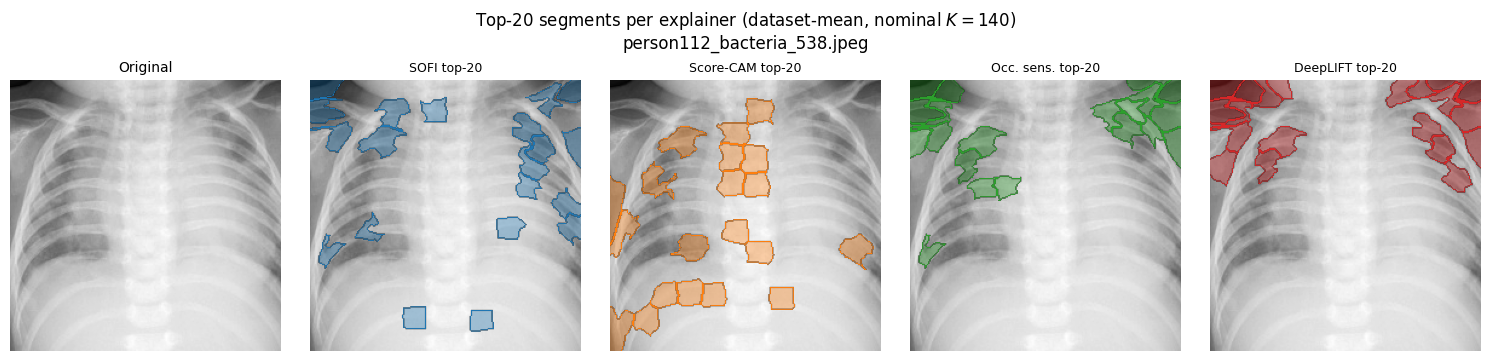

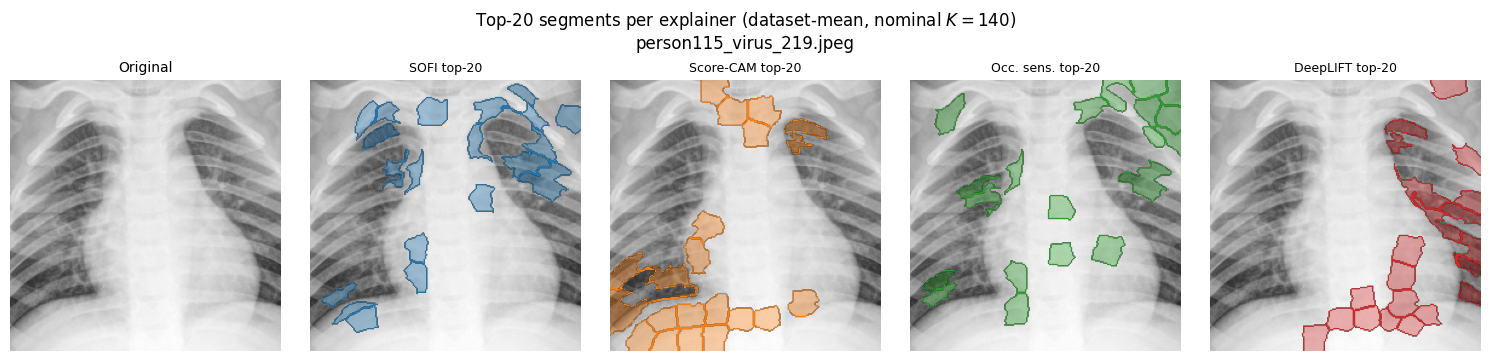

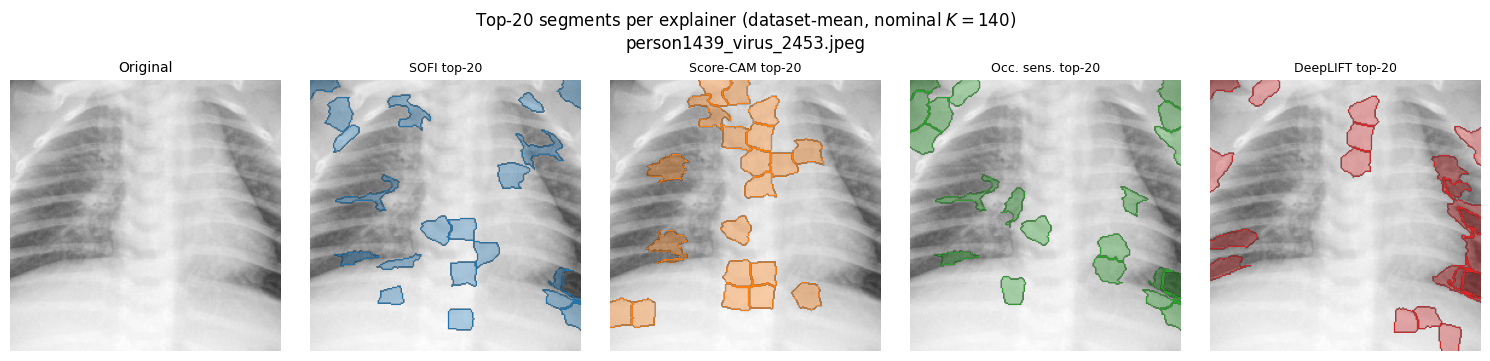

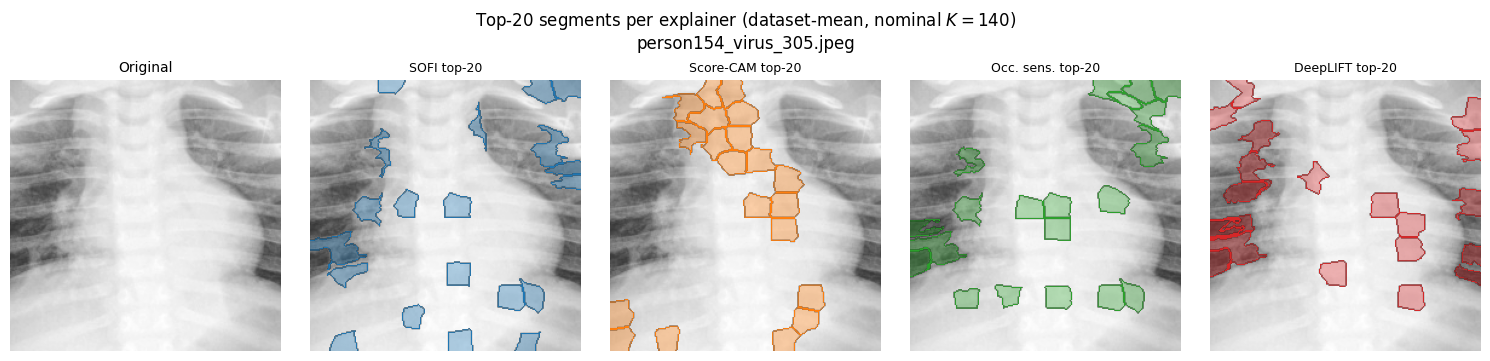

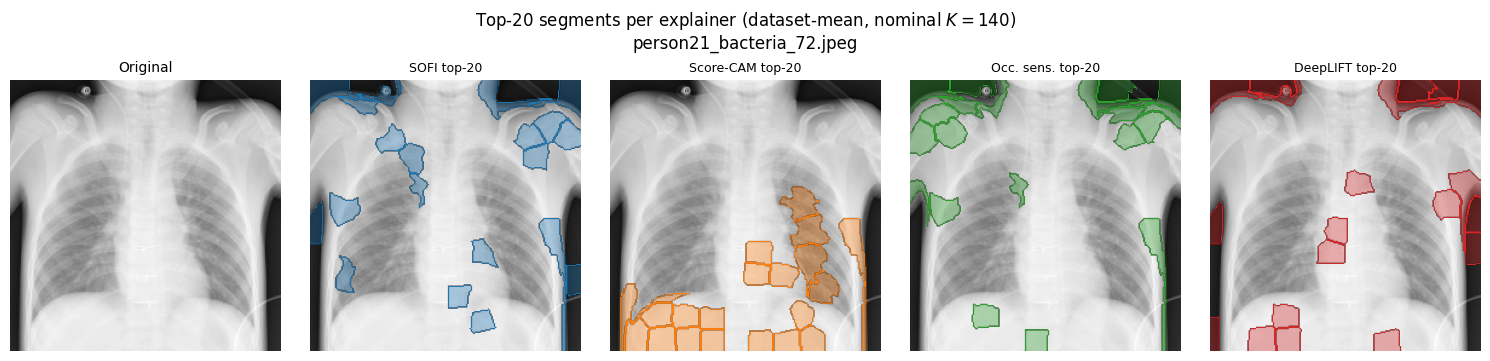

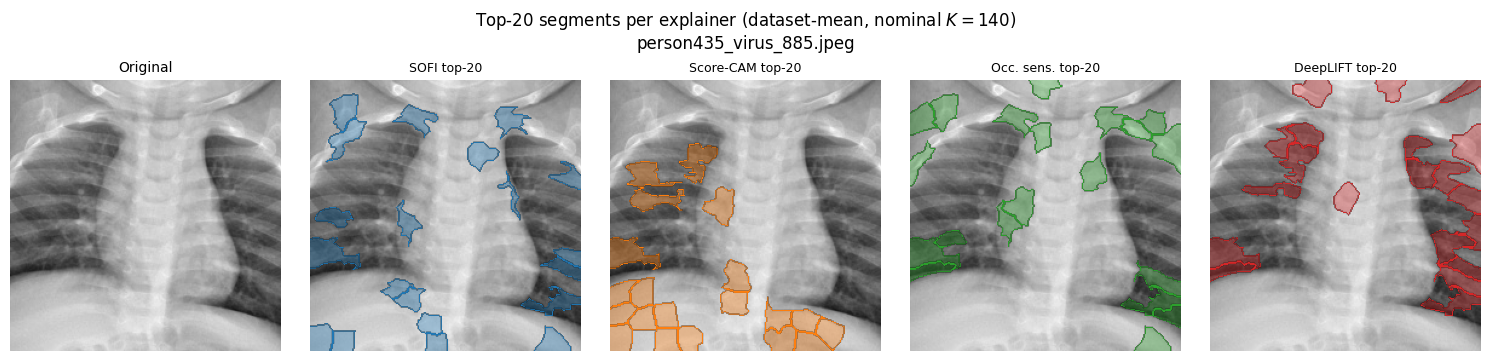

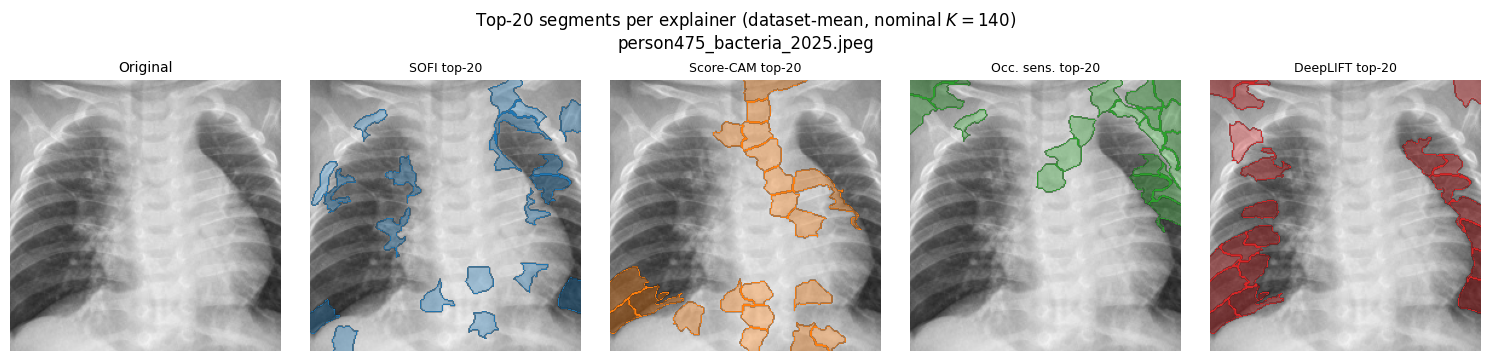

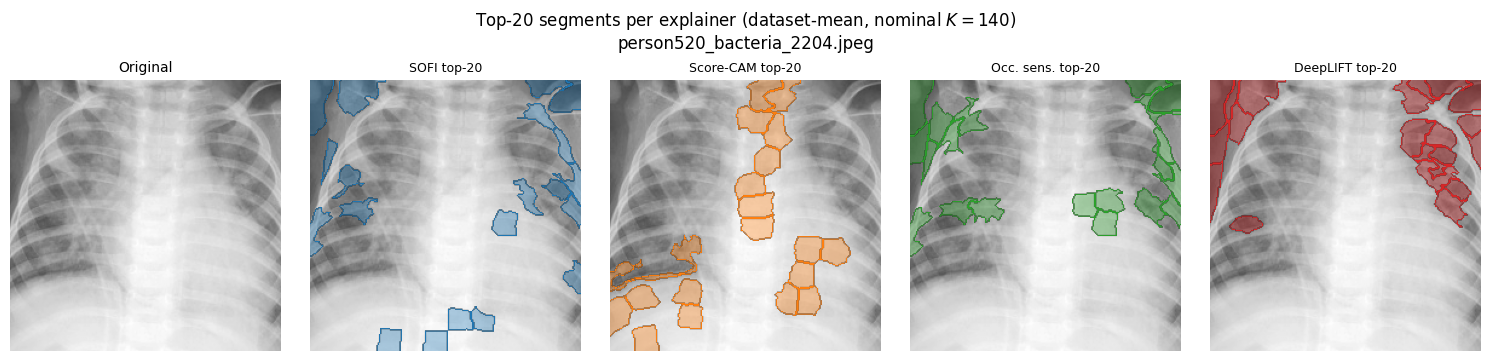

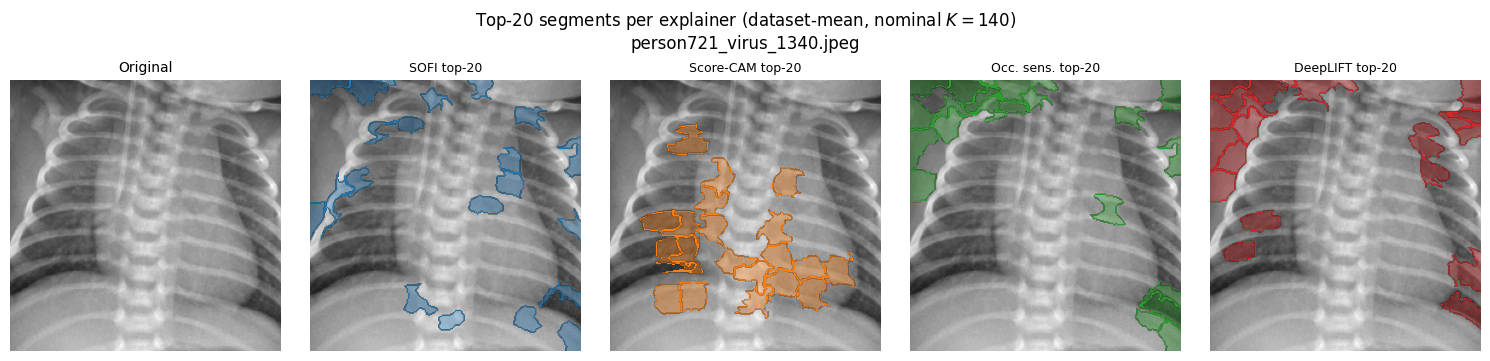

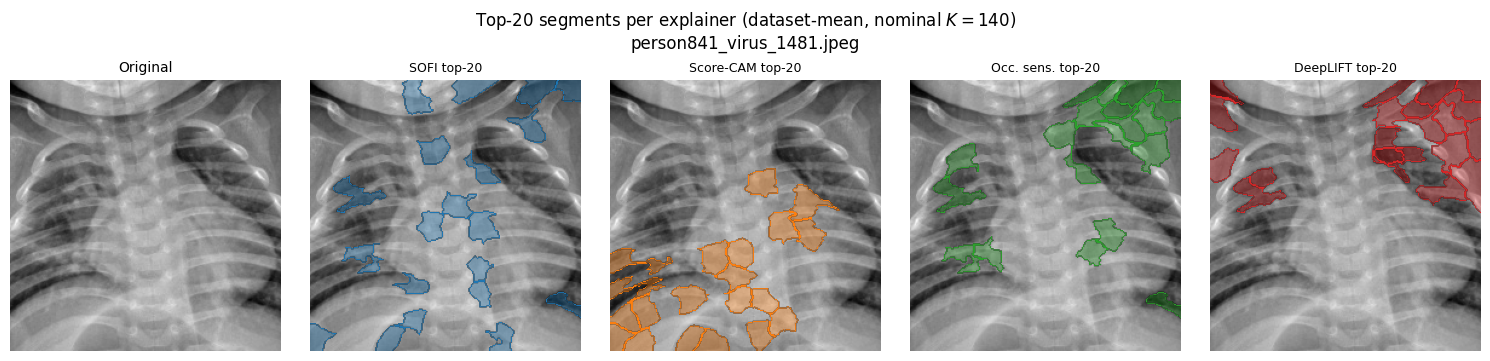

In [50]:
# pick one of your SOFI K=140 dataset-mean files
sofi_files = sorted(SOFI_ROOT.glob("*.npz"))
len(sofi_files), sofi_files[0]

for f in sofi_files:
  plot_top20_segments_all_methods(f, top_n=20)
